# Principal Componenet Analysis

This Jupyter Notebook is dedicated to understanding and implementing principal component analysis for soccer data. You can find the dataset [2022-2023 Soccer Player Stats Dataset](https://www.kaggle.com/datasets/vivovinco/20222023-football-player-stats?resource=download).

The following packages are required to run the attached code:

- [Matplotlib.pylab](https://matplotlib.org/2.0.2/api/pyplot_api.html)

- [Numpy](https://numpy.org/doc/)

- [Seaborn](https://seaborn.pydata.org/)

- [Pandas](https://pandas.pydata.org/docs/)

- [SciKit Learn](https://scikit-learn.org/stable/)

## Description of the Algoirthm:

***
- Principal Component Analysis (PCA) is a dimensionality reduction technique used in machine learning and data analysis.

- Its primary goal is to reduce the dimensionality of a dataset while preserving as much of its variance as possible. PCA achieves this by transforming the original features into a new set of orthogonal (uncorrelated) features called principal components.

You can see an example of this here:

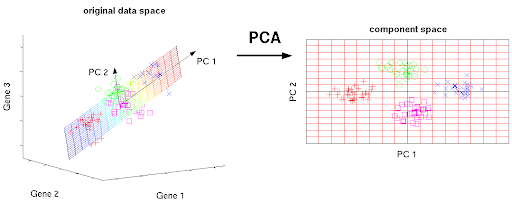

As you can see, PCA can successfully take something linear in many dimensions and bring it down to fewer dimensions, making data processing and our favorite machine learning algorithms easier.

- The key steps of PCA are as follows:

  - Standardization: The input features are standardized (i.e., scaled to have zero mean and unit variance) to ensure that each feature contributes equally to the analysis.

  - Covariance Matrix Computation: PCA computes the covariance matrix of the standardized data, which describes the relationships between pairs of features.

  - Eigenvalue Decomposition: PCA decomposes the covariance matrix into its eigenvectors and eigenvalues. The eigenvectors represent the directions (principal components) of maximum variance in the data, while the eigenvalues indicate the amount of variance explained by each principal component.

  - Dimensionality Reduction: PCA selects a subset of the eigenvectors (principal components) that capture the most variance in the data. The number of principal components chosen determines the dimensionality of the reduced dataset.

  - Projection: Finally, PCA projects the original data onto the selected principal components to obtain the reduced-dimensional representation of the dataset.

- PCA is widely used data visualization, noise reduction, feature extraction, and speeding up machine learning algorithms by reducing the dimensionality of the input space.

- Note that PCA assumes linear relationships between predictors and may not perform well if this assumption is violated.

Image source: [NLPCA](http://www.nlpca.org/pca_principal_component_analysis.html).
***

## Implementing the Algorithm:

***
Let's go into a little more depth on how to implement the algorithm:

1. Standardizing:

To standardize the data, we take each predictor, $x$, and subtract the mean and divide by the standard deviation.

This leaves us with $z = \frac{x - \text{mean}}{\text{standard devation}}$.

2. Computing the Covariance Matrix:

Then, we can get the covariance by multiplying our X matrix of predictors by it's transpose leaving us with a m by m square matrix.

We divide this by $\frac{1}{n-1}$, or the degrees of freedom where X is a m x n matrix meaning it has n predictors.

The resulting matrix will have variances along the diagonal and covariances everywhere else. This matrix is also symmetric to looking at the (a,b) term will be the same as the (b,a) term.

3. Finding the eigenvalues:

Next, let's find the eigenvalues.

Because S is symmetric, we can take $det(S−λI)=0$ and solve for the lambda eigenvalues.

4. Dimensionality Reduction:

Sort the eigenvalues in descending order. The eigenvalues represent the amount of variance explained by each principal component -- the predictors, so you want to prioritize the components with the highest variance, so we are including the predictors that actually impact the response.

Then, choose the top k eigenvectors corresponding to the
k largest eigenvalues to form the principal components. The appropriate number of componenets (or dimensions you choose) may change!

5. Projecting:

Finally, we can project our data onto the chosen componenets.

We can project to the two principal component axis by taking the 2 predictors that explain the most of the variance.

We can measure the fraction of variance each components explain by taking $\frac{\lambda_{i}}{\lambda_{1} + \lambda_{2} + \lambda_{3} ... + \lambda_{m}}$ where $\lambda$ represents the $i$th eigenvalue.


***

## Setting Up:

***
Import the necessary modules.
***

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.decomposition import PCA

***
Import our data. We will use more predictors for our classification this time.
***

In [72]:
#Import the dataset.
soccer = pd.read_csv("soccer_stats.csv", encoding='ISO-8859-1', delimiter=';')

# Filter the data such that we are only including players who have player more than 7.5 games worth of time.
soccer = soccer[soccer['90s'] >= 7.5]

# Filter to only include forwards and defenders.
data = soccer[(soccer['Pos'] == 'FW') | (soccer['Pos'] == 'DF')]

# Get the data for our model. Include goals, minutes, PKs, Assists, and Shot Creating Actions.
predictors = data[['Goals', '90s', 'SoT', 'Clr', 'ShoPK', 'Assists', 'SCA']].values
response = [[int(val)] for val in (data['Pos'] == 'FW')]
response = np.ravel(response)

# Split the data into training and testing sets.
train_p, test_p, train_r, test_r = train_test_split(predictors, response, test_size = 0.4, random_state = 42)


***
Fit the PCA model and get the principal components.
***

In [73]:
# Instantiate a PCA model projecting to 2 dimensions.
pca = PCA(n_components=2)

# Fit the model with our data
fit_pca = pca.fit_transform(train_p)

# Get the principal components.
components = pca.components_

***
Get the names of the chosen componenets.
***

In [74]:
# Find the index of predictors with the highest loadings for each component.
chosen_predictors_indices = np.argmax(np.abs(components), axis=1)

# Write down the predictor names.
predictor_names = ['Goals', '90s', 'SoT', 'ShoDist', 'ShoPK', 'Assists', 'SCA']

# Get the names of the chosen predictors.
chosen_predictors = [predictor_names[i] for i in chosen_predictors_indices]

# Print the chosen predictors.
for i, predictor in enumerate(chosen_predictors):
    print(f"Principal Component {i+1}: {predictor}")

Principal Component 1: 90s
Principal Component 2: Goals


It seems like 90s (minutes played divided by 90) and goals do the best job of predicting the players positions.

***
Let's get the explain variance for each selected predictor.
***

In [75]:
# ShoDist explained variance.
print(f"90s explained variance: {(pca.explained_variance_ratio_)[0]}")

# 90s explained variance.
print(f"Goals explained variance: {(pca.explained_variance_ratio_)[1]}")

# Total explained variance.
print(f"Total explained variance: {sum(pca.explained_variance_ratio_)}")

90s explained variance: 0.5577070020967657
Goals explained variance: 0.35879988860659384
Total explained variance: 0.9165068907033596


This means that around 92% of the variance in our model is explained by just two predictors. This is pretty good, as we are mostly predicting the variance of the model with 2/7 of our original predictors.

***
Let's plot our results.
***

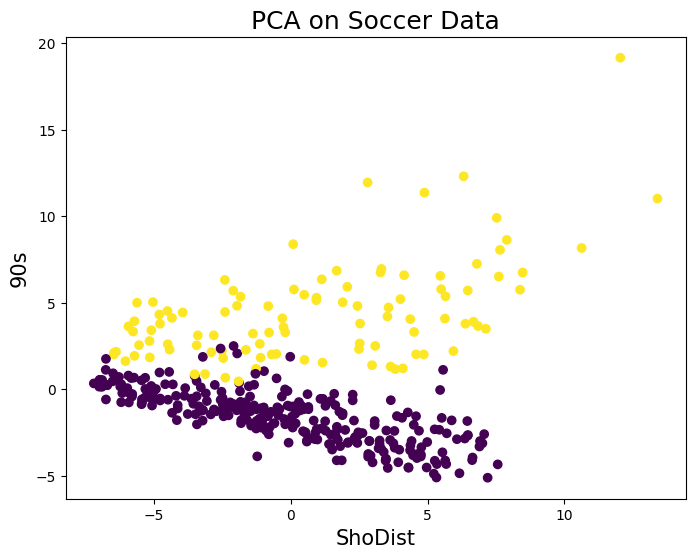

In [76]:
import matplotlib.pyplot as plt

# Set the figure size.
plt.figure(figsize=(8, 6))

# Plot the data.
plt.scatter(fit_pca[:, 0], fit_pca[:, 1], c = train_r, cmap= 'viridis')

# Add the title and axis labels.
plt.title('PCA on Soccer Data', size = 18)
plt.xlabel('ShoDist', size = 15)
plt.ylabel('90s', size = 15)

plt.show()

As we can see, the data has now been move to 2 dimensions and we can see and interpret the results!

It seems clear that there is a split between the forwards and defenders.

***
But what is the best number of components to include?
***

Each additional component decreases interpretabilibility and increases complexity, but taking away components loses some of the variability of the data.

Let's see how our data fares:

In [106]:
# Get the possible number of dimensions.
components = [i for i in range(1, 8)]

# Create a list to store the variability ratios.
variabilities = []

# Iterate through the dimensions.
for i in components:
  # Instantiate a PCA model projecting to i dimensions.
  pca = PCA(n_components = i)

  # Fit the model with our data.
  fit_pca = pca.fit_transform(train_p)

  # Get the amount of variability.
  variabilities.append(sum(pca.explained_variance_ratio_))

***
Let's plot the results.
***

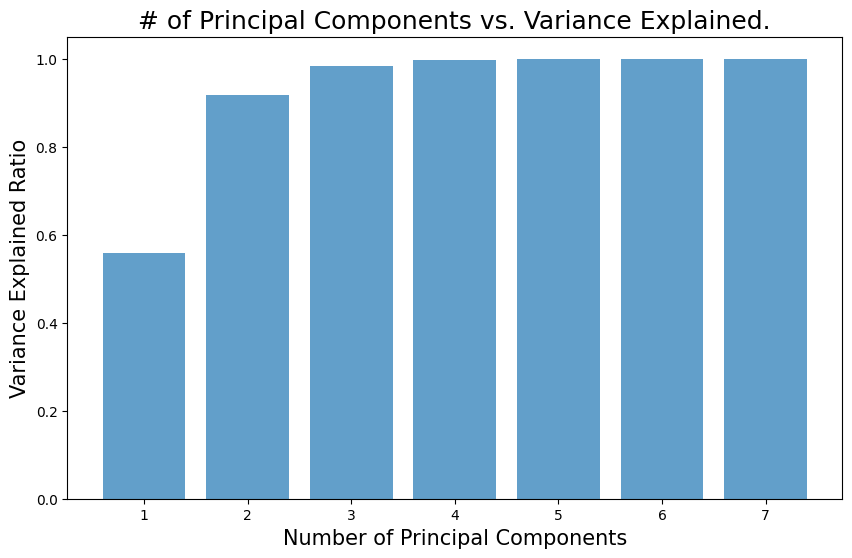

In [105]:
# Set the figure size.
plt.figure(figsize=(10, 6))

# Plot the data.
plt.bar(components, variabilities, alpha=0.7, align='center')

# Plot the labels.
plt.xlabel('Number of Principal Components', size = 15)
plt.ylabel('Variance Explained Ratio', size = 15)
plt.title('# of Principal Components vs. Variance Explained.', size = 18)
plt.xticks(components)
plt.show()

As we can see, the vast majority of the variability is explained by the first three principal components, so it definitely seems like it makes sense to reduce the number of dimensions!

## Conclusions:

***
- Dimensionality Reduction: PCA is a powerful technique for reducing the dimensionality of data while preserving most of its variance.

- Interpretation of Components: PCA facilitates the interpretation of the underlying structure of the data by identifying the principal components that capture the most significant sources of variation.

- Explained Variance: The explained variance ratio of each principal component provides insight into the proportion of variance in the data accounted for by that component.

PCA seems like an effective way to simplify datasets given many predictors and large amounts of data while maintaining the soul of the dataset. I'm excited to use it in the future!
***